In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

In [18]:
# Veri yükleme
train_df = pd.read_csv('PM_train.csv')
test_df = pd.read_csv('PM_test.csv')
truth_df = pd.read_csv('PM_truth.csv')

In [19]:

# Veri ön işleme
def preprocess_data(df):
    # Gereksiz sütunları kaldır
    df = df.drop(['setting3', 's1', 's5', 's10', 's16', 's18', 's19'], axis=1)
    
    # Her motor için son cycle'ı bul
    last_cycles = df.groupby('id')['cycle'].max().reset_index()
    last_cycles.columns = ['id', 'max_cycle']
    
    # Her satır için RUL (Remaining Useful Life) hesapla
    df = pd.merge(df, last_cycles, on='id', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [20]:
# Özellik seçimi
features = ['setting1', 'setting2', 'cycle'] + [f's{i}' for i in range(2, 22) if i not in [5, 10, 16, 18, 19]]
X_train = train_df[features]
y_train = train_df['RUL']

In [21]:
# Veriyi ölçeklendir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [22]:
# XGBoost modelini oluştur ve eğit
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
# Test verisi için tahminler
X_test = test_df[features]
X_test_scaled = scaler.transform(X_test)
test_df['RUL_predicted'] = model.predict(X_test_scaled)

In [24]:
# Her motor için son tahmin
final_predictions = test_df.groupby('id')['RUL_predicted'].last().reset_index()
final_predictions = pd.merge(final_predictions, truth_df, on='id', how='left')

In [25]:
# Truth verisindeki gerçek RUL değerlerini kullan
if 'RUL' in truth_df.columns:
    true_rul_column = 'RUL'
elif 'cycle' in truth_df.columns:
    true_rul_column = 'cycle'
    final_predictions[true_rul_column] = final_predictions[true_rul_column].astype(float)
else:
    raise ValueError("Truth verisinde RUL veya cycle sütunu bulunamadı.")

In [26]:
# Performans değerlendirme
mse = mean_squared_error(final_predictions[true_rul_column], final_predictions['RUL_predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(final_predictions[true_rul_column], final_predictions['RUL_predicted'])

print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R-squared Score: {r2:.4f}')

Root Mean Squared Error: 25.8842
R-squared Score: 0.6120


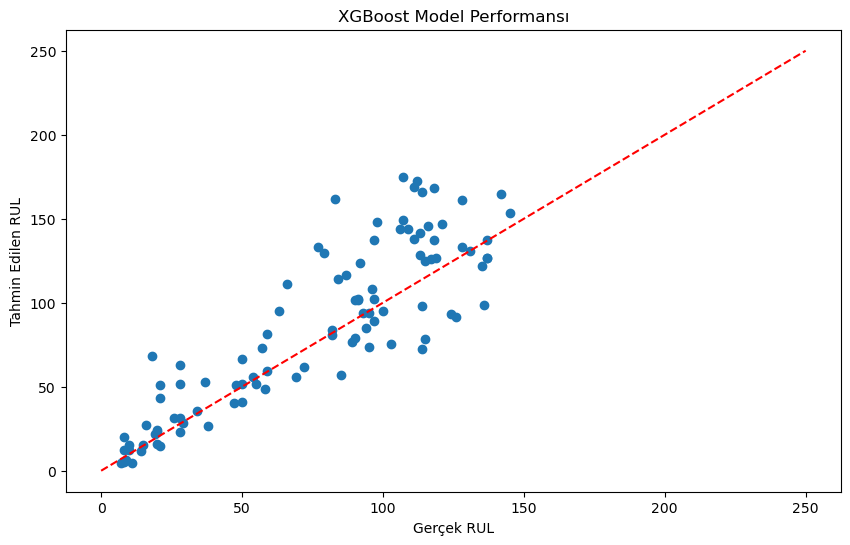

In [27]:
# Tahmin vs Gerçek değer grafiği
plt.figure(figsize=(10, 6))
plt.scatter(final_predictions[true_rul_column], final_predictions['RUL_predicted'])
plt.plot([0, 250], [0, 250], 'r--')
plt.xlabel('Gerçek RUL')
plt.ylabel('Tahmin Edilen RUL')
plt.title('XGBoost Model Performansı')
plt.show()

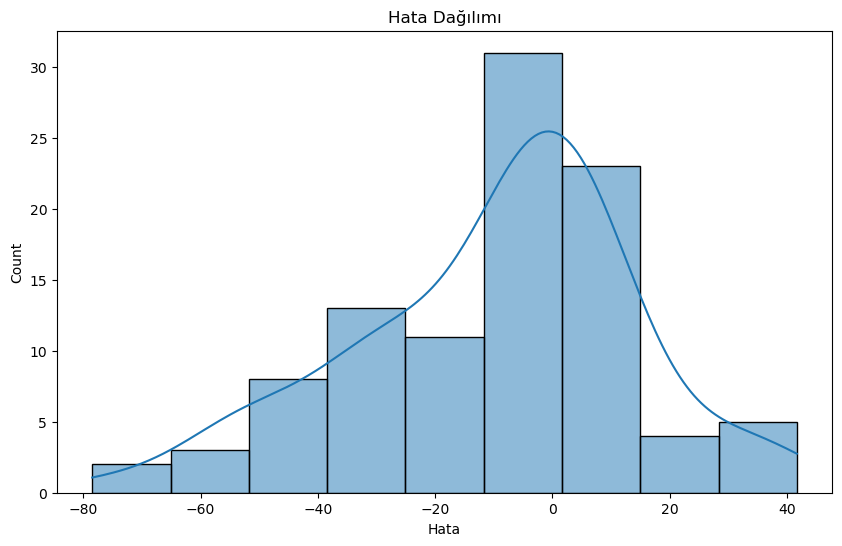

In [28]:
# Hata analizi
final_predictions['error'] = final_predictions[true_rul_column] - final_predictions['RUL_predicted']
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions['error'], kde=True)
plt.title('Hata Dağılımı')
plt.xlabel('Hata')
plt.show()

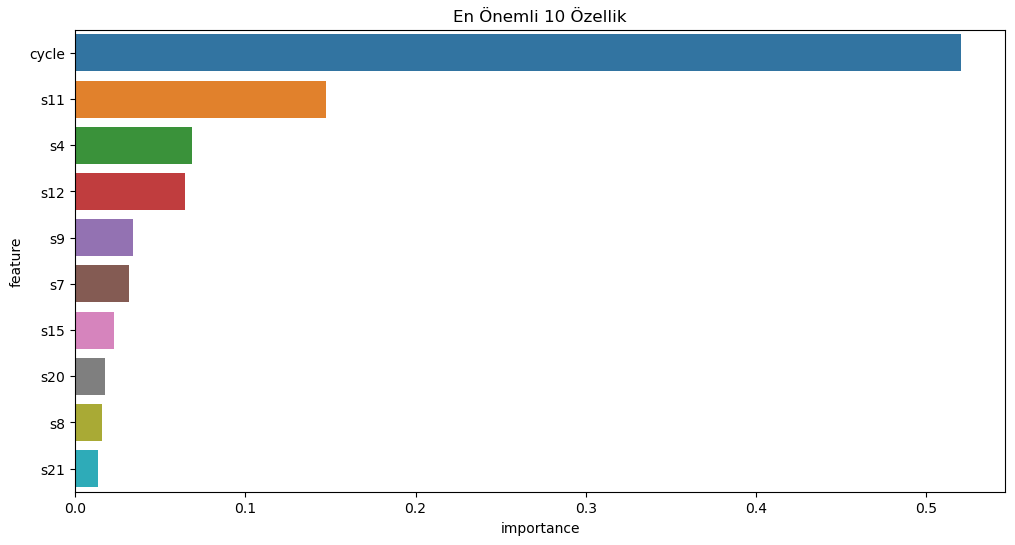

In [29]:
# Özellik önem sıralaması
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('En Önemli 10 Özellik')
plt.show()

In [30]:
# Bakım tahminleri
def format_maintenance_prediction(row):
    id = row['id']
    predicted_rul = row['RUL_predicted']
    hours = round(predicted_rul)
    if hours <= 0:
        return f"Motor ID {id}: ACİL BAKIM GEREKLİ! Tahmini kalan ömür süresi aşılmış."
    elif hours < 50:
        return f"Motor ID {id}: DİKKAT! Yakın zamanda bakım gerekli. Tahmini kalan süre: {hours} saat."
    elif hours < 100:
        return f"Motor ID {id}: Bakım planlanmalı. Tahmini kalan süre: {hours} saat."
    else:
        return f"Motor ID {id}: İyi durumda. Tahmini kalan süre: {hours} saat."

final_predictions['maintenance_message'] = final_predictions.apply(format_maintenance_prediction, axis=1)

print("\nBakım Tahminleri:")
for message in final_predictions['maintenance_message']:
    print(message)


Bakım Tahminleri:
Motor ID 1.0: İyi durumda. Tahmini kalan süre: 172 saat.
Motor ID 2.0: İyi durumda. Tahmini kalan süre: 148 saat.
Motor ID 3.0: Bakım planlanmalı. Tahmini kalan süre: 56 saat.
Motor ID 4.0: Bakım planlanmalı. Tahmini kalan süre: 84 saat.
Motor ID 5.0: İyi durumda. Tahmini kalan süre: 102 saat.
Motor ID 6.0: Bakım planlanmalı. Tahmini kalan süre: 94 saat.
Motor ID 7.0: İyi durumda. Tahmini kalan süre: 102 saat.
Motor ID 8.0: Bakım planlanmalı. Tahmini kalan süre: 74 saat.
Motor ID 9.0: İyi durumda. Tahmini kalan süre: 138 saat.
Motor ID 10.0: İyi durumda. Tahmini kalan süre: 108 saat.
Motor ID 11.0: Bakım planlanmalı. Tahmini kalan süre: 89 saat.
Motor ID 12.0: Bakım planlanmalı. Tahmini kalan süre: 93 saat.
Motor ID 13.0: Bakım planlanmalı. Tahmini kalan süre: 94 saat.
Motor ID 14.0: İyi durumda. Tahmini kalan süre: 149 saat.
Motor ID 15.0: İyi durumda. Tahmini kalan süre: 161 saat.
Motor ID 16.0: İyi durumda. Tahmini kalan süre: 114 saat.
Motor ID 17.0: Bakım planla

In [31]:
# Accuracy hesaplama
def calculate_accuracy(y_true, y_pred, threshold=100):
    y_true_class = (y_true <= threshold).astype(int)
    y_pred_class = (y_pred <= threshold).astype(int)
    accuracy = accuracy_score(y_true_class, y_pred_class)
    conf_matrix = confusion_matrix(y_true_class, y_pred_class)
    class_report = classification_report(y_true_class, y_pred_class)
    return accuracy, conf_matrix, class_report

y_true = final_predictions[true_rul_column].values
y_pred = final_predictions['RUL_predicted'].values

accuracy, conf_matrix, class_report = calculate_accuracy(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.7900

Confusion Matrix:
[[26  7]
 [14 53]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71        33
           1       0.88      0.79      0.83        67

    accuracy                           0.79       100
   macro avg       0.77      0.79      0.77       100
weighted avg       0.81      0.79      0.79       100



In [32]:
# Farklı eşik değerleri için accuracy hesapla
thresholds = [50, 100, 150, 200]
for threshold in thresholds:
    acc, _, _ = calculate_accuracy(y_true, y_pred, threshold)
    print(f"Accuracy (threshold={threshold}): {acc:.4f}")

Accuracy (threshold=50): 0.9100
Accuracy (threshold=100): 0.7900
Accuracy (threshold=150): 0.9100
Accuracy (threshold=200): 1.0000


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Sonuçları kaydet
final_predictions.to_csv('xgboost_predictions.csv', index=False)